# Making our own Transpilation Process using the PassManager.
Up to now we've shown how to use predefined transpilation processes by setting the `optimization_level` parameter to a value from `0 to 3`. However, to create our own quantum compiler toolchain, we must be able to create a customized transpilation process. This is accomplished by using a **sequence of Transpiler passes** which are managed by the **PassManager**. These passes act directly on the Directed Acyclic Graph (DAG) representation of the quantum circuit. There are two types of passes we can 
use, which are:

1) **Analysis Pass**: Can read and save specific DAG properties (save the information of a particular node in the DAG). 

2) **Transformation Pass**: Can Modify the DAG (adding gates, etc.), but has read-only access to the circuit properties.

[HERE](https://qiskit.org/documentation/apidoc/transpiler_passes.html) you can see a list of the defined transpiler passes used in Qiskit. They are also printed out in the following cell for convenience.

In [1]:
from qiskit.transpiler import passes

[transpiler_pass for transpiler_pass in dir(passes) if transpiler_pass[0].isupper()]

['ALAPSchedule',
 'ASAPSchedule',
 'AlignMeasures',
 'ApplyLayout',
 'BIPMapping',
 'BarrierBeforeFinalMeasurements',
 'BasicSwap',
 'BasisTranslator',
 'CSPLayout',
 'CXCancellation',
 'CXDirection',
 'CheckCXDirection',
 'CheckGateDirection',
 'CheckMap',
 'Collect1qRuns',
 'Collect2qBlocks',
 'CollectMultiQBlocks',
 'CommutationAnalysis',
 'CommutativeCancellation',
 'ConsolidateBlocks',
 'ContainsInstruction',
 'CountOps',
 'CountOpsLongestPath',
 'CrosstalkAdaptiveSchedule',
 'DAGFixedPoint',
 'DAGLongestPath',
 'Decompose',
 'DenseLayout',
 'Depth',
 'DynamicalDecoupling',
 'EchoRZXWeylDecomposition',
 'EnlargeWithAncilla',
 'Error',
 'FixedPoint',
 'FullAncillaAllocation',
 'GateDirection',
 'GatesInBasis',
 'HoareOptimizer',
 'InverseCancellation',
 'Layout2qDistance',
 'LayoutTransformation',
 'LookaheadSwap',
 'MergeAdjacentBarriers',
 'NoiseAdaptiveLayout',
 'NumTensorFactors',
 'Optimize1qGates',
 'Optimize1qGatesDecomposition',
 'Optimize1qGatesSimpleCommutation',
 'Optimi

## Customized Transpilation pipeline

### Example 1: Simple Circuit
**Step 0:** Lets define our backend and get some of its properties and see its qubit connectivity(i.e. **coupling_map**)

This backend is called fake_athens, and is on version 1.3.13. 
It has 5 qubits. 
It supports OpenPulse programs. 
The basis gates supported on this device are ['id', 'rz', 'sx', 'x', 'cx', 'reset']. 
Coupling Map: [[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3]]



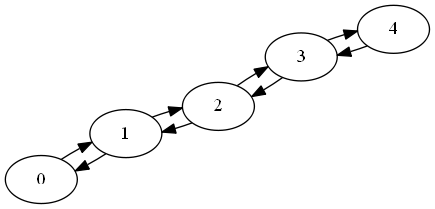

In [2]:
from qiskit import IBMQ
from qiskit.tools.jupyter import *
from qiskit.test.mock import FakeAthens
from qiskit.transpiler import CouplingMap

# Define a simulated noisy backend
simulated_backend = FakeAthens()



# Print out basic features of this backend. Note, I am using a function found in Backend_Resource2
config = simulated_backend.configuration()
print("This backend is called {0}, and is on version {1}. \nIt has {2} qubit{3}. \nIt "
      "{4} OpenPulse programs. \nThe basis gates supported on this device are {5}. \nCoupling Map: {6}\n"
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates,
                config.coupling_map))

cm = CouplingMap(config.coupling_map)
cm.draw()

**Step 1:** We begin with a basic circuit.

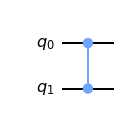

In [3]:
# For Passes
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller


# Define your circuit
circ = QuantumCircuit(2)
#circ.ccx(0, 1, 2)
circ.cz(0,1);
circ.draw(output='mpl')

Lets see what this circuit looks like as a DAG.

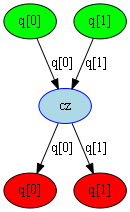

In [4]:
# For drawing DAG
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag
from qiskit.tools.visualization import dag_drawer

# Required software to visually see DAG
!pip install pydot

dag = circuit_to_dag(circ)
dag_drawer(dag)

**Step 2:** We expand the circuit into a chosen basis gate set.

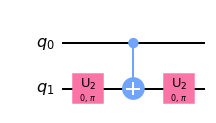

In [5]:
# Create a customized transpilation pipeline.
pm = PassManager()

# Pass 1: Expand a quantum circuit into the chosen basis set.
unroll_pass = Unroller(['u1', 'u2', 'u3', 'cx'])
pm.append(unroll_pass)


new_circ = pm.run(circ)
new_circ.draw(output='mpl')

Now, lets see what this expanded circuit looks like as a DAG.

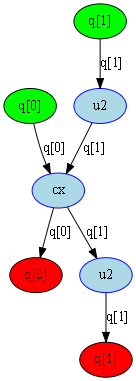

In [6]:
dag = circuit_to_dag(new_circ)
dag_drawer(dag)

**Step 3:** Use additional passes on the expanded gate set.

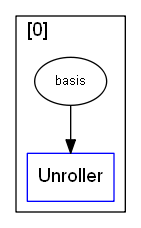

In [7]:
# Pass n: Can append as many passes as you want.

# Lets print out list of passes we are currently using.
pm.draw()

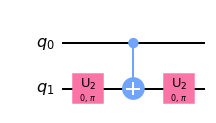

In [8]:
new_circ = pm.run(circ)
new_circ.draw(output='mpl')

Finally, lets see what kind of DAG we have after applying multiple passes.

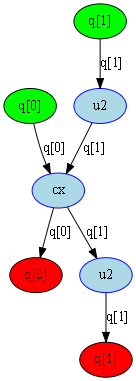

In [9]:
dag = circuit_to_dag(new_circ)
dag_drawer(dag)

## Example 2: Recreating the transpilation process for B-V circuit at optimization_level=0 
Using `optimization_level=0` as the parameter for `transpile()` will 

In this section we will learn which exact transpiler passes are used when setting `optimization_level=0` for `transpile()`. We will specifically go over transpiling the B-V circuit. Simply put, in this example we will recreate the same transpilation pipeline used when `optimization_level=0`and produce the same circuit using our own transpilation pipeline(which is based on the passes used in `optimization_level=0`). Here are the steps:
1. Define our backend, get its properties and visualize its qubit connectivity(i.e. **coupling_map**).
2. Use the Berstein-Vazirani circuit for a 3 bit hidden string s.
3. Set up a Logger to save all of the passes used for the transpilation pipeline of `optimization_level=0`
4. Transpile using `optimization_level=0`.
5. Read text file containing all transpiler passes, store transpiler passes into a Pass Manager object. 







### Step 0: Lets define our backend, get its properties and visualize its qubit connectivity(i.e. **coupling_map**)

Here we will be using the `FakeBoeblingen()` backend and print out its basic information.
For more information of the backend please visit:
1) [Backend_Resource1](https://qiskit.org/documentation/stubs/qiskit.providers.models.BackendConfiguration.html#qiskit.providers.models.BackendConfiguration)

2) [Backend_Resource2](https://qiskit.org/documentation/tutorials/circuits_advanced/08_gathering_system_information.html)


This backend is called fake_boeblingen, and is on version 1.2.9. 
It has 20 qubits. 
It supports OpenPulse programs. 
The basis gates supported on this device are ['id', 'u1', 'u2', 'u3', 'cx']. 
Coupling Map: [[0, 1], [1, 0], [1, 2], [1, 6], [2, 1], [2, 3], [3, 2], [3, 4], [3, 8], [4, 3], [5, 6], [5, 10], [6, 1], [6, 5], [6, 7], [7, 6], [7, 8], [7, 12], [8, 3], [8, 7], [8, 9], [9, 8], [9, 14], [10, 5], [10, 11], [11, 10], [11, 12], [11, 16], [12, 7], [12, 11], [12, 13], [13, 12], [13, 14], [13, 18], [14, 9], [14, 13], [15, 16], [16, 11], [16, 15], [16, 17], [17, 16], [17, 18], [18, 13], [18, 17], [18, 19], [19, 18]]



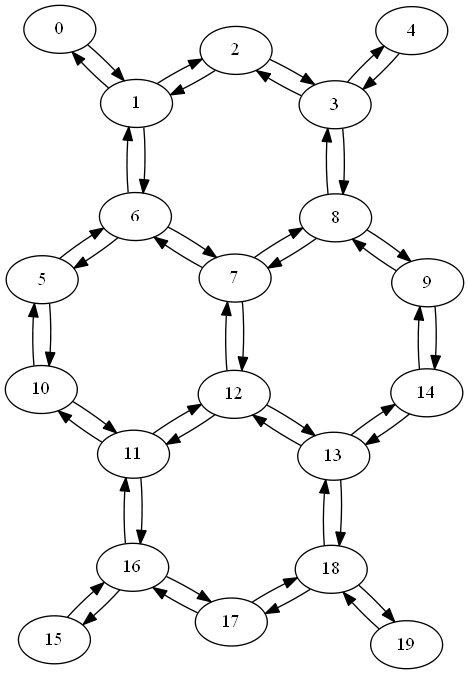

In [10]:
from qiskit import IBMQ
from qiskit.tools.jupyter import *
from qiskit.test.mock import FakeBoeblingen
from qiskit.transpiler import CouplingMap

# Define a simulated noisy backend
simulated_backend = FakeBoeblingen()



# Print out basic features of this backend. Note, I am using a function found in Backend_Resource2
config = simulated_backend.configuration()
print("This backend is called {0}, and is on version {1}. \nIt has {2} qubit{3}. \nIt "
      "{4} OpenPulse programs. \nThe basis gates supported on this device are {5}. \nCoupling Map: {6}\n"
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates,
                config.coupling_map))

cm = CouplingMap(config.coupling_map)
cm.draw()

### Step 1:  We begin with a small circuit that implements the BV algorithm for a 3 bit hidden string s. 

The source code is found on the Qiskit website, [HERE](https://qiskit.org/textbook/ch-algorithms/bernstein-vazirani.html#3.-Qiskit-Implementation--).

In [11]:
### Lets defined a new circuit of your choice with no measurements

s = '011'   # the hidden binary string
n = 3 # number of bits used to represent s


# We need a circuit with n qubits, plus one auxiliary qubit
# We also need n classical bits to write the output to
untranspiled_qc = QuantumCircuit(n+1, n)

# Put auxiliary in the minus state |->
# We leave the other n qubits in just |0>
untranspiled_qc.h(n)
untranspiled_qc.z(n)

# Apply Hadamard gates to each of the n "main" qubits (excluding the auxiliary)
# before querying the oracle
for i in range(n):
    untranspiled_qc.h(i)
    
# Apply barrier
untranspiled_qc.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        untranspiled_qc.i(q)
    else:
        untranspiled_qc.cx(q, n)
        
# Apply barrier
untranspiled_qc.barrier()

# Apply Hadamard gates after querying the oracle
for i in range(n):
    untranspiled_qc.h(i)


# Measurement
for i in range(n):
    untranspiled_qc.measure(i, i)

    
print('No Optimization')
print('Depth:', untranspiled_qc.depth())
print('Gate counts:', untranspiled_qc.count_ops())
untranspiled_qc.draw()

No Optimization
Depth: 6
Gate counts: OrderedDict([('h', 7), ('measure', 3), ('barrier', 2), ('cx', 2), ('z', 1), ('id', 1)])


┌───┐      ░                 ░ ┌───┐┌─┐      
q_0: ┤ H ├──────░───■─────────────░─┤ H ├┤M├──────
     ├───┤      ░   │             ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├──────░───┼─────────■───░─┤ H ├─╫─┤M├───
     ├───┤      ░   │  ┌───┐  │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├──────░───┼──┤ I ├──┼───░─┤ H ├─╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐└───┘┌─┴─┐ ░ └───┘ ║  ║ └╥┘
q_3: ┤ H ├┤ Z ├─░─┤ X ├─────┤ X ├─░───────╫──╫──╫─
     └───┘└───┘ ░ └───┘     └───┘ ░       ║  ║  ║ 
c: 3/═════════════════════════════════════╩══╩══╩═
                                          0  1  2

Print DAG of **untranspiled** circuit.

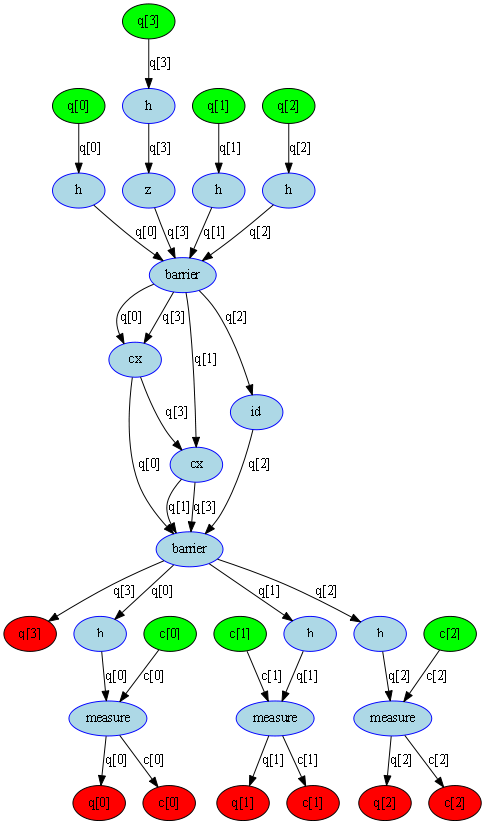

In [12]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag
from qiskit.tools.visualization import dag_drawer

# Required software to visually see DAG
!pip install pydot

# Draw DAG of the transpiled circuit that used optimization_level=0
dag = circuit_to_dag(untranspiled_qc)
dag_drawer(dag)

Print Measurement Results

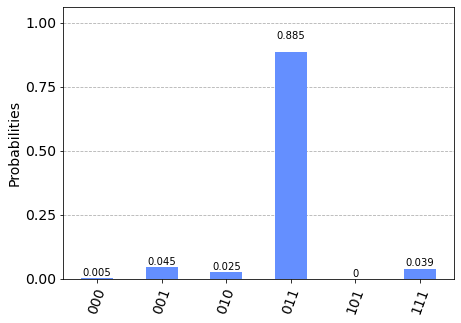

In [13]:
from qiskit.tools.visualization import plot_histogram

results_BV = simulated_backend.run(untranspiled_qc).result()
counts = results_BV.get_counts()
plot_histogram(counts)

### Step 2: Set up a Logger

Here, we will **save the passes used in the predefined transpilation pipeline of optimization_level=0**. Do not worry about this for now, we will use this later.

For more information about logging the list of transpilation passes for a predefined transpilation process, click **[HERE](https://qiskit.org/documentation/tutorials/circuits_advanced/04_transpiler_passes_and_passmanager.html#Transpiler-Logging)**.

For information about Logging, click **[HERE](https://docs.python.org/3/library/logging.html#levels)**.

In [14]:
import logging 

# Create and configure logger 
logging.basicConfig(filename="B-V_opt_lv0_passes.txt", filemode='w', format='%(asctime)s %(message)s') 

# Create an object 
logger=logging.getLogger('qiskit.transpiler') 

logger.setLevel('INFO')

formatter = logging.Formatter('%(asctime)s --- %(name)s --- %(processName)-10s --- %(levelname)s: %(message)s')
handler = logging.getLogger().handlers[0]
handler.setFormatter(formatter)

### Step 3: Transpile using `optimization_level=0`

This option does no optimization, so you end up using your input circuit on your hardware exactly as its been defined. This will give bad results, because your circuit does not even consider the device connectivity, there is no reduction of swap gates, etc.

In [15]:
transpiled_qc0 = transpile(untranspiled_qc, simulated_backend, optimization_level=0)  # No Optimization
print('Optimization Level 0')
print('Depth:', transpiled_qc0.depth())
print('Gate counts:', transpiled_qc0.count_ops())

# Print transpiled circuit
transpiled_qc0.draw()

Optimization Level 0
Depth: 12
Gate counts: OrderedDict([('cx', 11), ('u2', 7), ('barrier', 3), ('measure', 3), ('u1', 1), ('id', 1)])


┌─────────┐          ░      ┌───┐                         »
        q_0 -> 0 ┤ U2(0,π) ├──────────░───■──┤ X ├──■──────────────────────»
                 ├─────────┤          ░ ┌─┴─┐└─┬─┘┌─┴─┐          ┌───┐     »
        q_1 -> 1 ┤ U2(0,π) ├──────────░─┤ X ├──■──┤ X ├──■────■──┤ X ├──■──»
                 ├─────────┤          ░ └───┘┌───┐└───┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐»
        q_2 -> 2 ┤ U2(0,π) ├──────────░───■──┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├»
                 ├─────────┤┌───────┐ ░ ┌─┴─┐└─┬─┘┌─┴─┐├───┤└───┘     └───┘»
        q_3 -> 3 ┤ U2(0,π) ├┤ U1(π) ├─░─┤ X ├──■──┤ X ├┤ I ├───────────────»
                 └─────────┘└───────┘ ░ └───┘     └───┘└───┘               »
  ancilla_0 -> 4 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_1 -> 5 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_2 -> 6 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_3 -> 7 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_4 -> 8 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_5 -> 9 ──────────────────────────────────────────────────────────»
                                                                           »
 ancilla_6 -> 10 ──────────────────────────────────────────────────────────»
                                                                           »
 ancilla_7 -> 11 ──────────────────────────────────────────────────────────»
                                                                           »
 ancilla_8 -> 12 ──────────────────────────────────────────────────────────»
                                                                           »
 ancilla_9 -> 13 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_10 -> 14 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_11 -> 15 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_12 -> 16 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_13 -> 17 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_14 -> 18 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_15 -> 19 ──────────────────────────────────────────────────────────»
                                                                           »
            c: 3/══════════════════════════════════════════════════════════»
                                                                           »
«                       ░ ┌─────────┐ ░    ┌─┐   
«        q_0 -> 0 ──■───░─┤ U2(0,π) ├─░────┤M├───
«                 ┌─┴─┐ ░ └─────────┘ ░    └╥┘   
«        q_1 -> 1 ┤ X ├─░─────────────░─────╫────
«                 └───┘ ░ ┌─────────┐ ░ ┌─┐ ║    
«        q_2 -> 2 ──────░─┤ U2(0,π) ├─░─┤M├─╫────
«                       ░ ├─────────┤ ░ └╥┘ ║ ┌─┐
«        q_3 -> 3 ──────░─┤ U2(0,π) ├─░──╫──╫─┤M├
«                       ░ └─────────┘ ░  ║  ║ └╥┘
«  ancilla_0 -> 4 ────────────────────░──╫──╫──╫─
«                                     ░  ║  ║  ║ 
«  ancilla_1 -> 5 ────────────────────░──╫──╫──╫─
«                                     ░  ║  ║  ║ 
«  ancilla_2 -> 6 ────────────────────░──╫──╫──╫─
«     

Print DAG of **transpiled** circuit that used **optimization_level=0**.

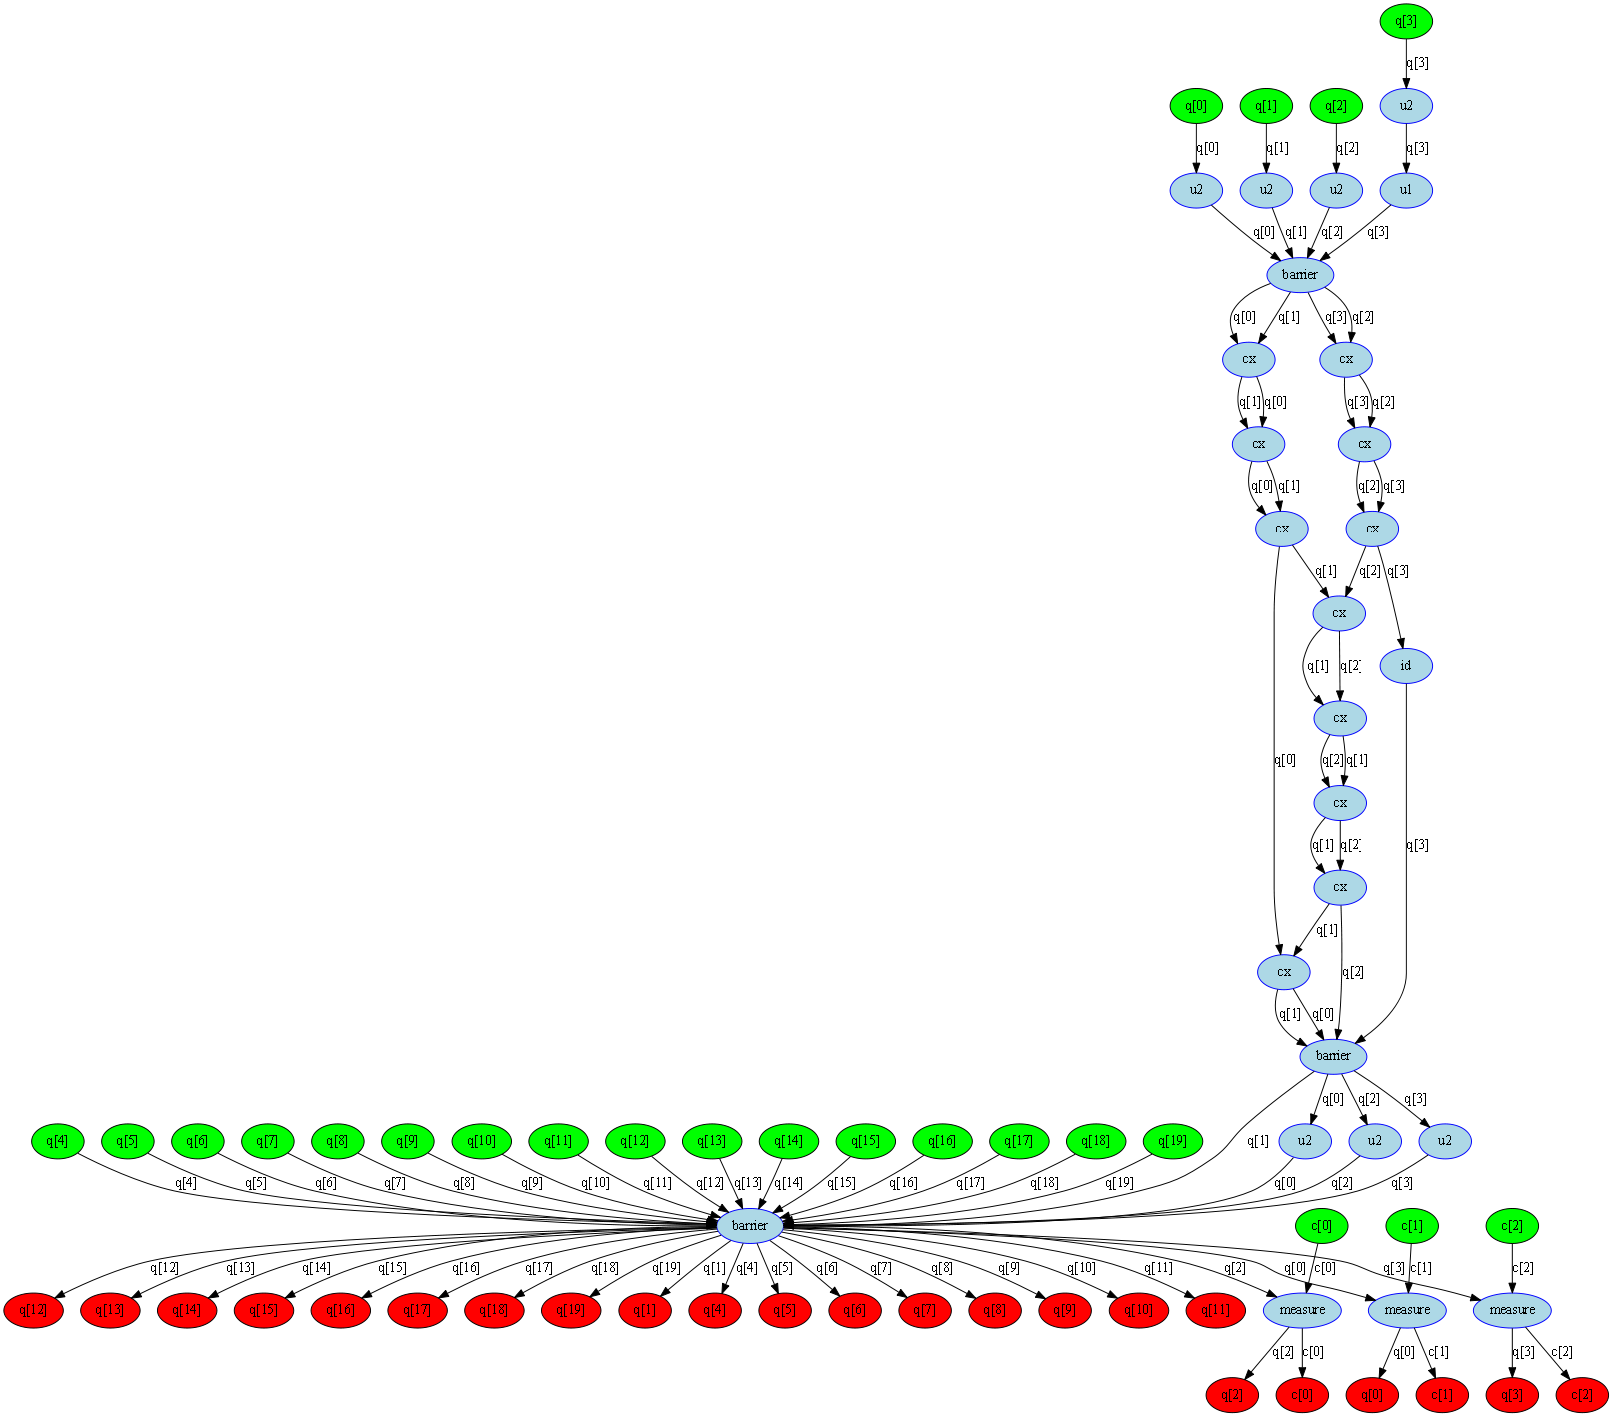

In [16]:
# Draw DAG of the transpiled circuit that used optimization_level=0
dag = circuit_to_dag(transpiled_qc0)
dag_drawer(dag)

Print Measurement Results

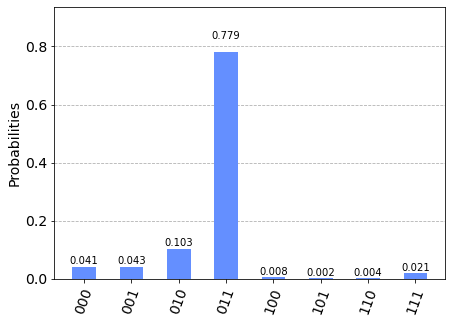

In [17]:
results_BV_Lev0 = simulated_backend.run(transpiled_qc0).result()
counts = results_BV_Lev0.get_counts()
plot_histogram(counts)

### Step: 4: Print passes used in `optimization_level=0`

In [18]:
path = "C:/Users/Danie/Documents/New/PIRQ_Draft/"+"Module 2"+"/Gate_Optimization/B-V_opt_lv0_passes.txt"

f = open(path, 'r')
content = f.read()
print(content)
f.close()

2022-06-23 17:41:43,543 --- qiskit.transpiler.runningpassmanager --- MainProcess --- INFO: Pass: SetLayout - 0.00000 (ms)
2022-06-23 17:41:43,543 --- qiskit.transpiler.runningpassmanager --- MainProcess --- INFO: Pass: UnitarySynthesis - 0.00000 (ms)
2022-06-23 17:41:43,544 --- qiskit.transpiler.runningpassmanager --- MainProcess --- INFO: Pass: Unroll3qOrMore - 0.00000 (ms)
2022-06-23 17:41:43,544 --- qiskit.transpiler.runningpassmanager --- MainProcess --- INFO: Pass: TrivialLayout - 0.00000 (ms)
2022-06-23 17:41:43,544 --- qiskit.transpiler.runningpassmanager --- MainProcess --- INFO: Pass: FullAncillaAllocation - 0.00000 (ms)
2022-06-23 17:41:43,544 --- qiskit.transpiler.runningpassmanager --- MainProcess --- INFO: Pass: EnlargeWithAncilla - 0.00000 (ms)
2022-06-23 17:41:43,545 --- qiskit.transpiler.runningpassmanager --- MainProcess --- INFO: Pass: ApplyLayout - 0.00000 (ms)
2022-06-23 17:41:43,545 --- qiskit.transpiler.runningpassmanager --- MainProcess --- INFO: Pass: CheckMap -

As you can see above, there are multiple passes used when `optimization_level=0`. Our goalnow is to:

1. Pass this exact sequence of passes to a new PassManager object
2. Use the PassManager Object on our untranspiled B-V circuit
3. Obtain the same circuit as the transpiled B-V circuit using optimization_level=0

### Step 5: Read text file containing all transpiler passes, store transpiler passes into a Pass Manager object. 

In [19]:
# Read in file and store passes into PassManager object
# TODO



# Create a customized transpilation pipeline.
pm = PassManager()
# Pass 1: TODO
# pm.append(<pass_here>)



# Print out diagram of PassManager to see the list of passes we are currently using.
pm.draw()

Use **your transpilation pipeline** on the **untranspiled circuit**, then print you **new transpiled circuit**.

Because we used the same passes as the predefined transpilation process that used `optimization_level=0`, then we expect the same circuit.

In [20]:
my_transpiled_qc = pm.run(untranspiled_qc)
my_transpiled_qc.draw()

┌───┐      ░                 ░ ┌───┐┌─┐      
q_0: ┤ H ├──────░───■─────────────░─┤ H ├┤M├──────
     ├───┤      ░   │             ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├──────░───┼─────────■───░─┤ H ├─╫─┤M├───
     ├───┤      ░   │  ┌───┐  │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├──────░───┼──┤ I ├──┼───░─┤ H ├─╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐└───┘┌─┴─┐ ░ └───┘ ║  ║ └╥┘
q_3: ┤ H ├┤ Z ├─░─┤ X ├─────┤ X ├─░───────╫──╫──╫─
     └───┘└───┘ ░ └───┘     └───┘ ░       ║  ║  ║ 
c: 3/═════════════════════════════════════╩══╩══╩═
                                          0  1  2

Print DAG of **transpiled** circuit that used **your transpilation pipeline**.

Similarly, we expect the same DAG.

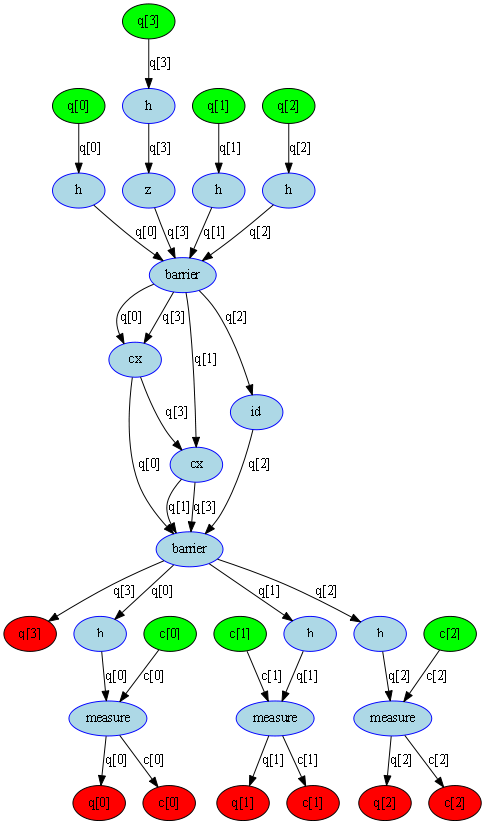

In [21]:
# Draw DAG of the transpiled circuit that used optimization_level=0
dag = circuit_to_dag(my_transpiled_qc)
dag_drawer(dag)

Print Measurement Results

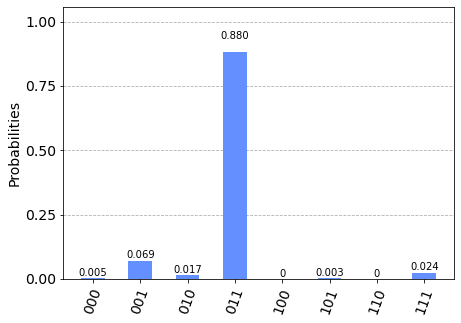

In [22]:
from qiskit.tools.visualization import plot_histogram

results_BV = simulated_backend.run(my_transpiled_qc).result()
counts = results_BV.get_counts()
plot_histogram(counts)

### Step 6: Done